In [ ]:
import h5py
import numpy as np
import tensorflow as tf
from tqdm.autonotebook import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.io import FixedLenFeature, parse_single_example

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
all_data = ['/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-01-30--11-24-51.h5', # 8 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-01-30--13-46-00.h5', # 9 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-01-31--19-19-25.h5', # 3 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-02-02--10-16-58.h5', # 8.5 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-02-08--14-56-28.h5', # 4 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-02-11--21-32-47.h5', # 13 GB xX
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-03-29--10-50-20.h5', # 12 GB x
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-04-21--14-48-08.h5', # 4.6 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-05-12--22-20-00.h5', # 7.8 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-06-02--21-39-29.h5', # 6.75 GB xx
            '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-06-08--11-46-01.h5'] # 2.7 GB xx

all_labels = ['/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-01-30--11-24-51.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-01-30--13-46-00.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-01-31--19-19-25.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-02-02--10-16-58.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-02-08--14-56-28.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-02-11--21-32-47.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-03-29--10-50-20.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-04-21--14-48-08.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-05-12--22-20-00.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-06-02--21-39-29.h5', 
              '/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/log/2016-06-08--11-46-01.h5']

# Convert single images to TFRecords

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(example):
    """Serialize an item in a dataset
    Arguments:
      example {[list]} -- list of dictionaries with fields "name" , "_type", and "data"

    Returns:
      [type] -- [description]
    """
    dset_item = {}
    for key in example.keys():
        dset_item[key] = example[key]["_type"](example[key]["data"])
        example_proto = tf.train.Example(features=tf.train.Features(feature=dset_item))
    return example_proto.SerializeToString()

In [ ]:
for data_file, label_file in list(zip(all_data, all_labels))[3:]:

  print('Currently on: ', data_file)
  # Open Files
  h5_file = h5py.File(data_file, 'r')
  h5_labels = h5py.File(label_file, 'r')

  # Extract Data
  mydata = h5_file['X'] # uint8 -> _bytes_feature
  speed_labels = np.array(h5_labels['speed']) # float64 -> _float_feature
  angle_labels = np.array(h5_labels['steering_angle']) # float64 -> _float_feature
  gear_labels = np.array(h5_labels['gear_choice']) # float64 -> _float_feature

  # Get acceleration
  speed_shifted = np.roll(speed_labels, 1)
  speed_shifted[0] = 0
  acc_labels = (speed_labels - speed_shifted)/0.05 # float64 -> _float_feature

  print('Previous Lengths')
  print(speed_labels.shape[0])

  assert speed_labels.shape[0] == angle_labels.shape[0] == gear_labels.shape[0] == acc_labels.shape[0], f'File {label_file} has components with different shapes'
  # Sample
  idxs = np.linspace(0, speed_labels.shape[0] - 1, mydata.shape[0]).astype("int")
  speed_labels = speed_labels[idxs]
  angle_labels = angle_labels[idxs]
  gear_labels = gear_labels[idxs]
  acc_labels = acc_labels[idxs]

  print('New Lengths')
  print(speed_labels.shape[0])

  # Number of items
  assert speed_labels.shape[0] == angle_labels.shape[0] == gear_labels.shape[0] == acc_labels.shape[0]
  num_of_items = mydata.shape[0]
  # Write TFRecords
  print('Writing TFRecords File')
  with tf.io.TFRecordWriter(str(data_file.replace('camera', 'TFRecords/Data_2').replace('.h5', '.tfrecord'))) as writer:

      for row in tqdm(range(num_of_items)):

        gear = gear_labels[row]
        if gear == 0 or gear == 10: # Reversing or Parked
          continue
        speed = speed_labels[row]
        angle = angle_labels[row]        
        acc = acc_labels[row]
        img = mydata[row]
        img_resized = tf.image.resize(np.moveaxis(img, 0, -1), [100, 100]).numpy().astype('uint8')
        assert len(img_resized.shape) == 3, 'Should have 3D img'

        fields = {
            'X': {'data': img_resized.flatten().tobytes(), '_type': _bytes_feature},
            'speed': {'data': speed, '_type': _float_feature}, 
            'steering_angle': {'data': angle, '_type': _float_feature},
            'acceleration': {'data': acc, '_type': _float_feature}
            }

        example = serialize_example(fields)
        writer.write(example)
  h5_file.close()
  h5_labels.close()

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-02-02--10-16-58.h5
Previous Lengths
280785
New Lengths
56166
Writing TFRecords File


  0%|          | 0/56166 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-02-08--14-56-28.h5
Previous Lengths
129344
New Lengths
25865
Writing TFRecords File


  0%|          | 0/25865 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-02-11--21-32-47.h5
Previous Lengths
426596
New Lengths
85296
Writing TFRecords File


  0%|          | 0/85296 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-03-29--10-50-20.h5
Previous Lengths
392182
New Lengths
78463
Writing TFRecords File


  0%|          | 0/78463 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-04-21--14-48-08.h5
Previous Lengths
152650
New Lengths
30538
Writing TFRecords File


  0%|          | 0/30538 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-05-12--22-20-00.h5
Previous Lengths
258571
New Lengths
51691
Writing TFRecords File


  0%|          | 0/51691 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-06-02--21-39-29.h5
Previous Lengths
223899
New Lengths
44792
Writing TFRecords File


  0%|          | 0/44792 [00:00<?, ?it/s]

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-06-08--11-46-01.h5
Previous Lengths
90870
New Lengths
18177
Writing TFRecords File


  0%|          | 0/18177 [00:00<?, ?it/s]

In [ ]:
# Approximatey 489,707 images

## Read Data

In [ ]:
raw_dataset = tf.data.TFRecordDataset([str("/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/TFRecords/Data_2/2016-01-30--11-24-51.tfrecord")])

In [ ]:
def _dtype_to_tf_feattype(dtype):
    """ convert tf dtype to correct tffeature format
    """
    if dtype in [tf.float32, tf.int64]:
        return dtype
    else:
        return tf.string

In [ ]:
def _parse_function(example_proto, data_types):
    """ parse dataset from tfrecord, and convert to correct format
    """
    # list features
    features = {
        lab: FixedLenFeature([], _dtype_to_tf_feattype(dtype))
        for lab, dtype in data_types.items()
    }
    # parse features
    parsed_features = parse_single_example(example_proto, features)
    feat_dtypes = [tf.float32, tf.string, tf.int64]
    
    # convert the features if they are in the wrong format
    parse_list = [
        parsed_features[lab]
        if dtype in feat_dtypes
        else tf.io.decode_raw(parsed_features[lab], dtype)
        for lab, dtype in data_types.items()
    ]
    return parse_list

In [ ]:
data_types = {
    "steering_angle": tf.float32,
    "speed": tf.float32,
    "X": tf.uint8,
}

In [ ]:
files = os.listdir('/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/TFRecords/Data_2')
files = list(map(lambda x: os.path.join('/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/TFRecords/Data_2', x), files))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x),
                           cycle_length=11, block_length=1)

dataset = dataset.map(lambda x: _parse_function(x, data_types=data_types))
dataset = dataset.shuffle(buffer_size=100000)
dataset = dataset.batch(128)

In [ ]:
ds = iter(dataset)

In [ ]:
angle, speed, x  = next(ds)

In [ ]:
x = tf.reshape(x, [128, 100, 100, 3])
#x = np.moveaxis(, 1, -1)

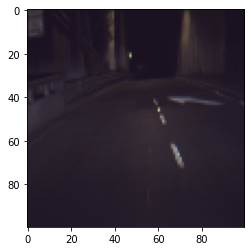

In [ ]:
plt.imshow(x[120])

# Convert Sequence of Images to TFRecords

In [ ]:
def image_sequence(image_list):
    """this function takes a list of images and returns the list in bytes"""
    image_bytes_list = []

    for image in image_list:
        image_bytes = image.tobytes()
        image_bytes = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
        image_bytes_list.append(image_bytes)

    return image_bytes_list

In [ ]:
timesteps = 100
interval = 10

In [ ]:
data_file = all_data[4]
label_file = all_labels[4]
h5_file = h5py.File(data_file, 'r')
h5_labels = h5py.File(label_file, 'r')

In [ ]:
for data_file, label_file in list(zip(all_data, all_labels))[6:7]:

  # Open Files
  print('Currently on: ', data_file)
  h5_file = h5py.File(data_file, 'r')
  h5_labels = h5py.File(label_file, 'r')

  # Extract Data
  mydata_1 = h5_file['X'] # uint8 -> _bytes_feature
  # Convert to np for faster retrieval
  mydata = np.empty(shape=mydata_1.shape, dtype=mydata_1.dtype)
  mydata[:] = mydata_1[:]
  # Get labels
  speed_labels = np.array(h5_labels['speed']) # float64 -> _float_feature
  angle_labels = np.array(h5_labels['steering_angle']) # float64 -> _float_feature
  gear_labels = np.array(h5_labels['gear_choice']) # float64 -> _float_feature

  assert speed_labels.shape[0] == angle_labels.shape[0] == gear_labels.shape[0], f'File {label_file} has components with different shapes'
  print('Previous Lengths')
  print(speed_labels.shape[0])
  print(angle_labels.shape[0])
  print(gear_labels.shape[0])

  # Sample
  idxs = np.linspace(0, speed_labels.shape[0] - 1, mydata.shape[0]).astype("int")
  speed_labels = speed_labels[idxs]
  angle_labels = angle_labels[idxs]
  gear_labels = gear_labels[idxs]
  print('New Lengths')
  print(speed_labels.shape[0])
  print(angle_labels.shape[0])
  print(gear_labels.shape[0])

  # Number of items
  assert speed_labels.shape[0] == angle_labels.shape[0] == gear_labels.shape[0]
  num_of_items = mydata.shape[0]
  
  # Write TFRecords
  print('Writing TFRecords File')
  with tf.io.TFRecordWriter(str(data_file.replace('camera', 'TFRecords/Memory').replace('.h5', '.tfrecord'))) as writer:

      for row in tqdm(range(num_of_items)):

          if row >= timesteps:
            speed = speed_labels[row]
            angle = angle_labels[row]
            gear = gear_labels[row]
            if gear == 0 or gear == 10: # Reversing or Parked
              continue

            # create a feature list consisting of a sequence of images
            imgs = mydata[row-timesteps: row: interval]
            image_bytes_list = image_sequence(imgs)
            images = tf.train.FeatureList(feature=image_bytes_list)

            # Feature all values needed
            im_length = tf.train.Feature(int64_list=tf.train.Int64List(value=[len(image_bytes_list)]))
            im_height = tf.train.Feature(int64_list=tf.train.Int64List(value=[160]))
            im_width = tf.train.Feature(int64_list=tf.train.Int64List(value=[320]))
            im_depth = tf.train.Feature(int64_list=tf.train.Int64List(value=[3]))
            im_angle = tf.train.Feature(float_list=tf.train.FloatList(value=[angle]))
            im_speed = tf.train.Feature(float_list=tf.train.FloatList(value=[speed]))

            sequence_dict = {'X': images}
            sequence_list = tf.train.FeatureLists(feature_list=sequence_dict)
            
            context_dict = {'length': im_length, 'height': im_height, 'width': im_width, 'depth': im_depth, 'steering_angle': im_angle, 'speed': im_speed}
            sequence_context = tf.train.Features(feature=context_dict)

            example = tf.train.SequenceExample(context=sequence_context, feature_lists=sequence_list)
            writer.write(example.SerializeToString())
  h5_file.close()
  h5_labels.close()

Currently on:  /content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/camera/2016-03-29--10-50-20.h5
Previous Lengths
392182
392182
392182
New Lengths
78463
78463
78463
Writing TFRecords File


  0%|          | 0/78463 [00:00<?, ?it/s]

## Read Data

In [ ]:
data_file = all_data[0]
label_file = all_labels[0]
h5_file = h5py.File(data_file, 'r')
h5_labels = h5py.File(label_file, 'r')

In [ ]:
mydata = h5_file['X'] # uint8 -> _bytes_feature
speed_labels = np.array(h5_labels['speed']) # float64 -> _float_feature
angle_labels = np.array(h5_labels['steering_angle']) # float64 -> _float_feature
idxs = np.linspace(0, speed_labels.shape[0] - 1, mydata.shape[0]).astype("int")
speed_labels = speed_labels[idxs]
angle_labels = angle_labels[idxs]

In [ ]:
tf.constant(mydata)

In [ ]:
h = mydata
angle = angle_labels[10]

In [ ]:
image_bytes_list = image_sequence(h)
images = tf.train.FeatureList(feature=image_bytes_list)
im_length = tf.train.Feature(int64_list=tf.train.Int64List(value=[len(image_bytes_list)]))
im_height = tf.train.Feature(int64_list=tf.train.Int64List(value=[160]))
im_width = tf.train.Feature(int64_list=tf.train.Int64List(value=[320]))
im_depth = tf.train.Feature(int64_list=tf.train.Int64List(value=[3]))
im_angle = tf.train.Feature(float_list=tf.train.FloatList(value=[angle]))

In [ ]:
sequence_dict = {'Images': images}
sequence_list = tf.train.FeatureLists(feature_list=sequence_dict)

context_dict = {'length': im_length, 'height': im_height, 'width': im_width, 'depth': im_depth, 'steering_angle': im_angle}
sequence_context = tf.train.Features(feature=context_dict)

In [ ]:
with tf.io.TFRecordWriter('/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/TFRecords/Memory/test.tfrecord') as writer:
  example = tf.train.SequenceExample(context=sequence_context, feature_lists=sequence_list)
  writer.write(example.SerializeToString())

In [ ]:
def parse_sequence(sequence_example):

        sequence_features = {'X': tf.io.FixedLenSequenceFeature([], dtype=tf.string)}

        context_features = {'length': tf.io.FixedLenFeature([], dtype=tf.int64),
                         'height': tf.io.FixedLenFeature([], dtype=tf.int64),
                         'width': tf.io.FixedLenFeature([], dtype=tf.int64),
                         'depth': tf.io.FixedLenFeature([], dtype=tf.int64),
                         'steering_angle': tf.io.FixedLenFeature([], dtype=tf.float32),
                         'speed': tf.io.FixedLenFeature([], dtype=tf.float32)}

        context, sequence = tf.io.parse_single_sequence_example(sequence_example, context_features=context_features, sequence_features=sequence_features)

        # get features context
        seq_length = tf.cast(context['length'], dtype = tf.int32)
        im_height = tf.cast(context['height'], dtype = tf.int32)
        im_width = tf.cast(context['width'], dtype = tf.int32)
        im_depth = tf.cast(context['depth'], dtype = tf.int32)
        im_angle = context['steering_angle']
        im_speed = context['speed']

        # encode image
        image = tf.io.decode_raw(sequence['X'], tf.uint8)
        image = tf.reshape(image, shape=(seq_length, im_depth, im_height, im_width))

        return image, {'angle': im_angle, 'speed': im_speed}

In [ ]:
dataset = tf.data.TFRecordDataset('/content/drive/Shareddrives/ELEC 494 - Ω2Ω/Data/TFRecords/Memory/2016-01-30--11-24-51.tfrecord')
dataset = dataset.map(parse_sequence, num_parallel_calls=tf.data.AUTOTUNE)
# dataset = dataset.batch(3)

In [ ]:
i = 0
for img, dic in dataset:
  print(img.shape)
  print(dic)
  i+=1
  if i == 4:
    break

(10, 3, 160, 320)
{'angle': <tf.Tensor: shape=(), dtype=float32, numpy=1839.0972>, 'speed': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
(10, 3, 160, 320)
{'angle': <tf.Tensor: shape=(), dtype=float32, numpy=1687.9615>, 'speed': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
(10, 3, 160, 320)
{'angle': <tf.Tensor: shape=(), dtype=float32, numpy=1509.431>, 'speed': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
(10, 3, 160, 320)
{'angle': <tf.Tensor: shape=(), dtype=float32, numpy=1293.2565>, 'speed': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}


In [ ]:
n = iter(dataset)

In [ ]:
m = next(n)